In [12]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv(r'C:\Users\ashbat\Desktop\totalByWeekPriceSellWH.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'W-MON'

In [14]:
df.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,4785.659184,0
2016-03-21,7262.513382,2
2016-03-28,9176.321691,0
2016-04-04,9066.646440,0
2016-04-11,9226.801075,0


In [15]:
print(df.index.freq)

<Week: weekday=0>


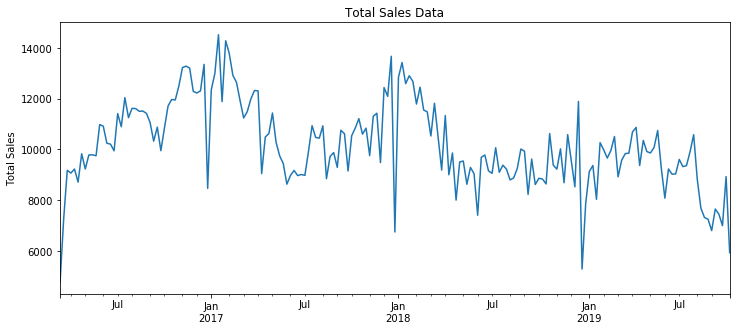

In [16]:
title='Total Sales Data'
ylabel='Total Sales'
xlabel='' 

ax = df['TOTAL_PRICESELL'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

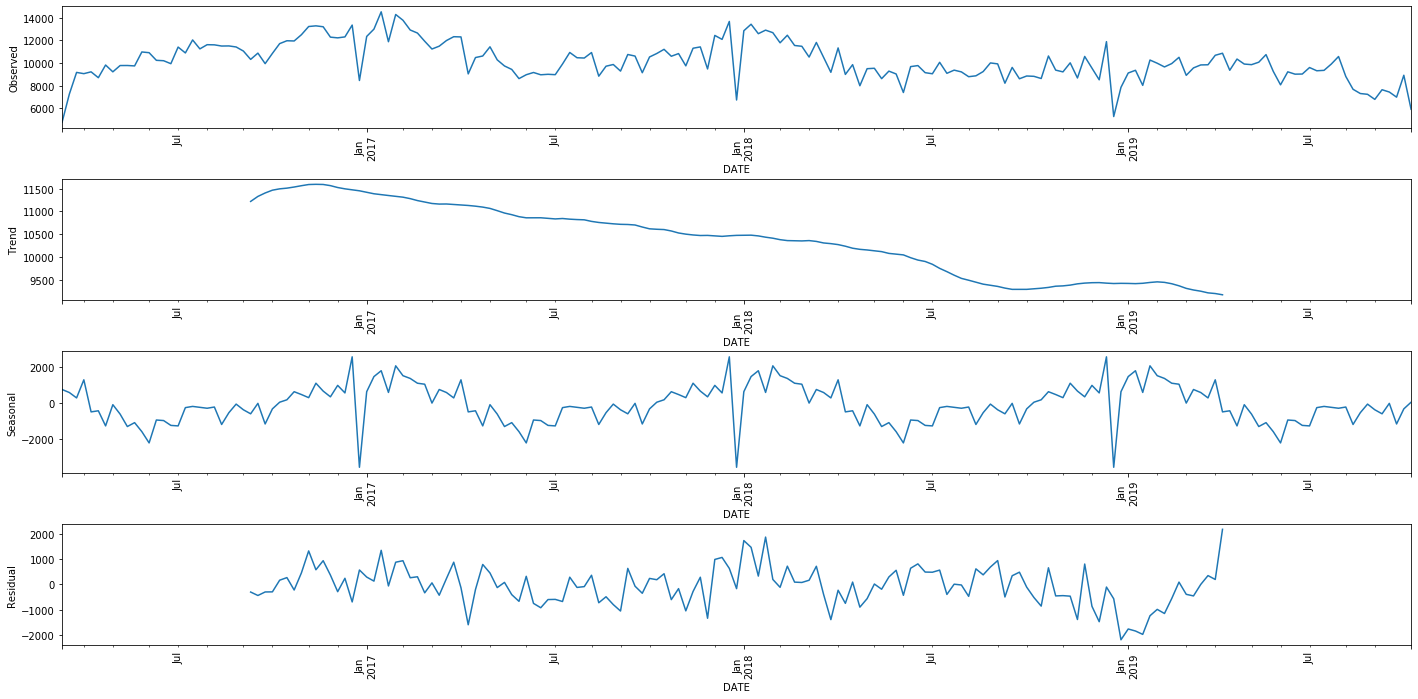

In [17]:
result = seasonal_decompose(df['TOTAL_PRICESELL'], model='add')

observed = result.observed
trend = result.trend
seasonal =  result.seasonal
residual =  result.resid

decomp_data = pd.DataFrame({"Observed":observed, "Trend": trend, "Seasonal":seasonal,"Residual":residual})

import matplotlib.pyplot as plt

figure, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10))
figure.tight_layout(pad=3.0)
for i, ax in enumerate(axes):
    ax = decomp_data.iloc[:,i].plot(ax=ax)
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(decomp_data.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

figure.savefig('totalsales_decomp.png')

In [18]:
#auto_arima(df['TOTAL_PRICESELL'],seasonal=True,m=52).summary()

In [19]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [20]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -1134.219
Date:                            Sun, 17 May 2020   AIC                           2276.438
Time:                                    11:32:39   BIC                           2288.029
Sample:                                03-14-2016   HQIC                          2281.148
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5056      0.061     -8.275      0.000      -0.625      -0.386
ar.S.L52      -0.2201      0.158     -1.392      0.164      -0.530       0.090
ma.S.L52       0.9105      0.164      5.565      0.000       0.590       1.231
sigma2      9.413e+05   2.46e-07   3.82e+12      0.000    9.41e+05    9.41e+05
===================================================================================
Ljung-Box (Q):                       20.73   Jarque-Bera (JB):                53.35
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.61
Prob(H) (two-sided):                  0.97   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.16e+27. Standard errors may be unstable.
"""

In [21]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

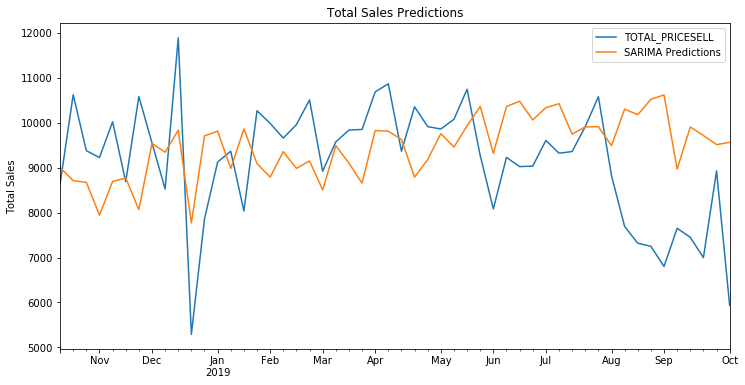

In [22]:
#Compare to validation data
title='Total Sales Predictions'
ylabel='Total Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [23]:
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMA MSE: {error1:11.10}')
print(f'SARIMA RMSE: {error2:11.10}')

SARIMA MSE: 2405605.718
SARIMA RMSE: 1551.001521


In [24]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA Forecast')

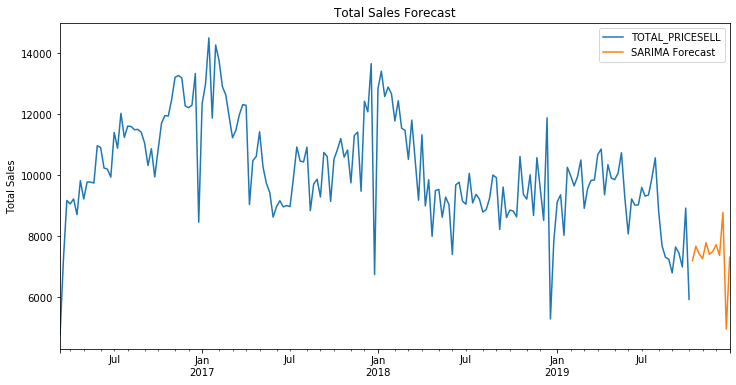

In [25]:
title='Total Sales Forecast'
ylabel='Total Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [26]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [27]:
train.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,4785.659184,0
2016-03-21,7262.513382,2
2016-03-28,9176.321691,0
2016-04-04,9066.646440,0
2016-04-11,9226.801075,0


In [28]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],exog=train['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -1131.275
Date:                            Sun, 17 May 2020   AIC                           2272.551
Time:                                    11:33:01   BIC                           2287.040
Sample:                                03-14-2016   HQIC                          2278.439
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
holidayWeekS  -565.1413    102.620     -5.507      0.000    -766.273    -364.010
ma.L1           -0.5124      0.059     -8.619      0.000      -0.629      -0.396
ar.S.L52        -0.3226      0.718     -0.449      0.653      -1.731       1.086
ma.S.L52         0.8412      1.673      0.503      0.615      -2.438       4.121
sigma2        9.993e+05   9.84e+05      1.015      0.310    -9.3e+05    2.93e+06
===================================================================================
Ljung-Box (Q):                       21.77   Jarque-Bera (JB):                90.62
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.36
Prob(H) (two-sided):                  0.41   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holidayWeekS']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMAX MSE: {error1:11.10}')
print(f'SARIMAX RMSE: {error2:11.10}')

SARIMAX MSE: 2171724.566
SARIMAX RMSE: 1473.677226


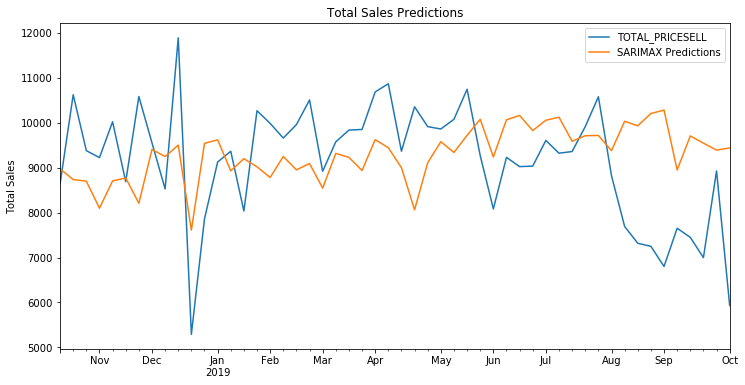

In [30]:
#Compare to validation data
title='Total Sales Predictions'
ylabel='Total Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [31]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],exog=df['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()

In [32]:
start=len(df)
end=len(df) + 11
exog_forecast = pd.read_csv(r'C:\Users\ashbat\Desktop\ExogHolidays.csv',index_col='DATE',parse_dates=True)
exog_forecast.index.freq = 'W-MON'
exog_forecast = exog_forecast[['holidayWeekS']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

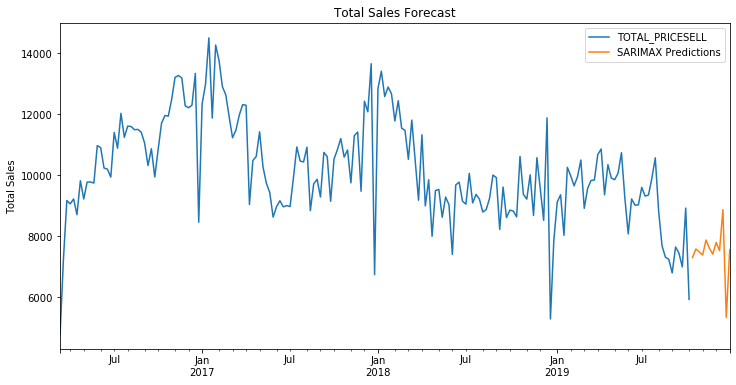

In [34]:
title='Total Sales Forecast'
ylabel='Total Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);